In [22]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

### 1. Estimation of AR Models

Here we can use OLS estimator, 

$$\hat{\alpha} = \left( \sum_{t=1}^{T}Y_{t-1}Y^{T}_{t-1}\right)^{-1}\sum_{t=1}^{T}Y_{t-1}y_t$$

Where $Y_{T-1} = (1, y_{t-1}, \ldots, y_{t-p})$

For the residuals, 

$$\hat{u_t} = y_t - Y_{T-1}\hat{\alpha}$$

### 2. Estimation of MA Models

More difficult than OLS, because non linearity in the parameters. We will use Maximum Likelihood method. 
Recall, 

$$f(y_1, \ldots, y_T) = f(y_1)\times f(y_2\vert y_1)\times \ldots \times f(y_T\vert y_{T-1}, \ldots y_1)$$

So, if we assume that __conditional distribution of $y_t$ is normal__, the log-likelihood function is: 

$$l(\alpha_1, \ldots, \alpha_p, m_1, \ldots, m_q) = \sum_{t=1}^{T}l_t(.)$$

where, 

$$l_t(.) = -\frac{1}{2}log(2\pi) -\frac{1}{2}log(\sigma_u^2) - \left( m(L)^{-1}\alpha(L)y_t \right)^2/2\sigma_u^2$$

This is because our assumption on gaussian conditional distribution: 

$$f(y_t\vert y_1, \ldots, y_{t-1}) = \frac{1}{\sigma_u \sqrt{2\pi}} exp\left( -\frac{1}{2\sigma_u^2}(y_t - \hat y_t) \right)$$

where, 

$$y_t - \hat y_t = u_t$$

### 3. Model Specification

#### 3.1 AR Processes

Specifying the kinds of models we have discussed so far requires deciding __the orders of the various operators and deterministic terms__. 

This can be done fitting a model, performing tests for model adequacy and model reduction. This approach is limited, parameters in an overfitted ARMA model may not be unique. 

Normally to look for AR model order look at the __partial autocorrelation function plot__

__*Look for model selection techniques on the book page 33*__

Many of the AR order selection criteria are of the form: 

$$Cr(n) = log(\tilde{\sigma_u}^2(n)) + c_T\varphi(n)$$

where, 

$$\tilde{\sigma_u}^2(n) = \frac{1}{T}\sum_{t=1}^{T}\hat{u}_t(n)$$

Is the error variance estimator based on the OLS residuals __from an AR model of order $n$__.

##### Explanation

- The first term on the right-hand side measures the fit of a model with order $n$.
- $c_T$ is a sequence indexed by the sample size
- $\varphi(n)$ is the order of the fitted process, __function penalizing large AR orders__.
- Sample size is assumed to be constant for all orders $n$, number of presampled values set aside for estimation of the first $y_t$ estimations is determined by the maximum order considered $p_{max}$ lets say. 

__We will choose the order minimizing $Cr(n)$, let's call it $\hat{p}$.__

##### Order-Criteria Examples

- $AIC(n) = log(\tilde{\sigma_u}^2(n)) + \frac{2}{T}n$
- $SC(n) = log(\tilde{\sigma_u}^2(n)) + \frac{log(T)}{T}n$

#### 3.1 ARMA Processes

Difficulty with this processes, is that we need the estimation of many models with different orders (AR and MA parts).
Cancellation of AR and MA parts are possible. 

Fit an $AR(h)$ model with large order $h$ by OLS to obtain residuals $\hat{u}_t(h)$. Then models of the form

$$y_t = \alpha_1y_{t-1} + \ldots + \alpha_n y_{t - n} + u_t+m_1\hat{u}_{t-1}(h) + \ldots + m_l\hat{u}_{t-l}(h)$$

are fitted for all combinations $(n,l)$. The combination of orders minimizing a criterion

$$Cr(n, l) = log(\tilde{\sigma_u}^2(n, l)) + c_T\varphi(n, l)$$

is chosen. 

##### Order-Criteria Examples

- $AIC(n) = log(\tilde{\sigma_u}^2(n)) + \frac{2}{T}(n+l)$

### 4. Example

First we will plot long-term interest rates on Germany dataset. Then we will plot PACF to see the order of AR model to use.

In [27]:
#Building long-term interest rates Dataframe ##########################
url_1 = "http://www.jmulti.de/download/datasets/Umlaufsrendite.dat"
df  = pd.read_csv(url_1, on_bad_lines='skip').iloc[:,:1]
df = df.iloc[:,0].str.split()[6:]
df_ir= pd.DataFrame(columns = ["Long Term Interest Rates"])
df_ir["Long Term Interest Rates"] = [float(element[0]) for element in df]


108

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


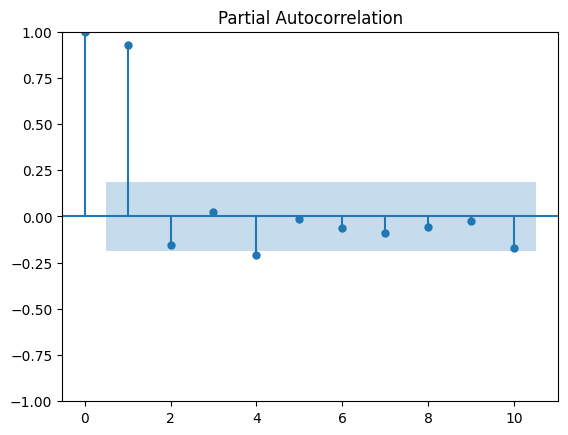

In [24]:
pacf = plot_pacf(df_ir["Long Term Interest Rates"], lags=10)

Watching the PACF closely, __it seems an AR(4) model suits better__.

In [59]:
mod = AutoReg(df_ir, 4, old_names=False)
res = mod.fit()
print(res.summary())
print(res.aicc)

                               AutoReg Model Results                                
Dep. Variable:     Long Term Interest Rates   No. Observations:                  108
Model:                           AutoReg(4)   Log Likelihood                 397.638
Method:                     Conditional MLE   S.D. of innovations              0.005
Date:                      Thu, 29 Dec 2022   AIC                           -783.277
Time:                              07:11:06   BIC                           -767.410
Sample:                                   4   HQIC                          -776.849
                                        108                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0048      0.003      1.796      0.072      -0.000       0.010
Long Term Interest Rates.L1     

In [65]:
def akaike(data, pmax):
    """
    Computing Akaike information criterion
    """
    output = dict()
    for n in range(1, pmax+1):
        res = AutoReg(data, n, old_names=False).fit()
        output[n] = res.aicc
    df = pd.DataFrame(data = list(output.values()), index = list(output.keys()))
    return df

<AxesSubplot:>

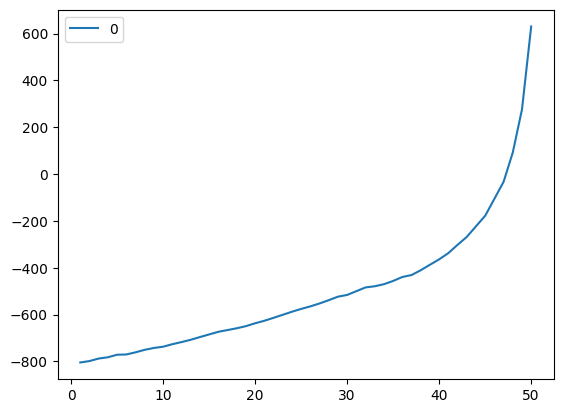